In [1]:
%reset -f
import time
t_start = time.time()

In [2]:
import sys

HOME_PATH = "../../"
sys.path.insert(0, HOME_PATH + "qe")

import os
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import shap
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sn
import my_cmaps
from numba import njit

2024-08-18 15:24:45.241157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to JupyROOT 6.28/04


In [3]:
# some constant
GEV = 1e-3
WORKERS = 64
RNG = np.random.default_rng(2024)
HOME_PATH = "../../"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
class EPConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        # Ensure that energy-momentum are time-like case
        px = w[:, 0]
        py = w[:, 1]
        pz = w[:, 2]
        energy = w[:, 3]
        # Calculate the constraint
        constraint = tf.maximum(0.0, energy**2 - px**2 - py**2 - pz**2)
        # Create a mask for invalid four-vectors (constraint == 0)
        mask = tf.cast(tf.not_equal(constraint, 0.0), w.dtype)
        # If constraint is zero, set the entire four-vector to zero
        adjusted_w = w * tf.expand_dims(mask, axis=-1)
        return adjusted_w


with tf.keras.utils.custom_object_scope({"EPConstraint": EPConstraint}):
    onshell_path = os.path.abspath(
        HOME_PATH + "5th_trial/w_lead_result/dnn_w_onshell.keras"
    )
    model_lead = tf.keras.models.load_model(onshell_path)
    model_lead.summary()
    onshell_path = os.path.abspath(
        HOME_PATH + "5th_trial/w_sublead_result/dnn_w_offshell.keras"
    )
    model_sublead = tf.keras.models.load_model(onshell_path)
    model_sublead.summary()

cla_path = os.path.abspath(HOME_PATH + "5th_trial/classifier/shell_classifier.keras")
model_cla = tf.keras.models.load_model(cla_path)
model_cla.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 flatten_1 (Flatten)         (None, 18)                0         
                                                                 
 dense_11 (Dense)            (None, 256)               4864      
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 1024)              263168    
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)              1049

2024-08-18 15:24:51.738554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41686 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-08-18 15:24:51.739401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 353 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [5]:
def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)

In [6]:
from dataclasses import dataclass

data_path = "/root/data/full_345324_data.h5"


@dataclass
class Lead_lep:
    px = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPx"]
    py = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPy"]
    pz = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPz"]
    energy = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepE"]
    pt = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPt"]
    eta = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "reco_leadlep")["RecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_lep:
    px = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPx"]
    py = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPy"]
    pz = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPz"]
    energy = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepE"]
    pt = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPt"]
    eta = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "reco_subleadlep")["RecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Met:
    px = pd.read_hdf(data_path, "reco_met")["RecoMETPx"]
    py = pd.read_hdf(data_path, "reco_met")["RecoMETPy"]
    phi = pd.read_hdf(data_path, "reco_met")["RecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Truth_lead_lep:
    px = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPx"]
    py = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPy"]
    pz = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPz"]
    energy = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepE"]
    pt = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPt"]
    eta = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepEta"]
    phi = pd.read_hdf(data_path, "truth_leadlep")["TruthRecoLeadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_lep:
    px = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPx"]
    py = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPy"]
    pz = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPz"]
    energy = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepE"]
    pt = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPt"]
    eta = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepEta"]
    phi = pd.read_hdf(data_path, "truth_subleadlep")["TruthRecoSubleadLepPhi"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_met:
    px = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPx"]
    py = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPy"]
    phi = pd.read_hdf(data_path, "truth_met")["TruthRecoMETPhi"]
    pt = pt(px, py)


@dataclass
class Lead_w:
    px = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPx"]
    py = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPy"]
    pz = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPz"]
    energy = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWE"]
    pt = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPt"]
    eta = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWEta"]
    phi = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWPhi"]
    m = pd.read_hdf(data_path, "truth_leadw")["TruthRecoLeadWM"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_w:
    px = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPx"]
    py = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPy"]
    pz = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPz"]
    energy = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWE"]
    pt = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPt"]
    eta = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWEta"]
    phi = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWPhi"]
    m = pd.read_hdf(data_path, "truth_subleadw")["TruthRecoSubleadWM"]
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T

In [7]:
# reco
lead_lep = Lead_lep()
sublead_lep = Sublead_lep()
met = Met()

# truth
truth_lead_lep = Truth_lead_lep()
truth_sublead_lep = Truth_sublead_lep()
truth_met = Truth_met()

# target Ws
w_lead = Lead_w()
w_sublead = Sublead_w()

In [8]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22 / GEV
print(len(lead_lep.pt) - np.sum(cut_pre_pt_lead*1))
cut_pre_pt_sub = sublead_lep.pt > 15 / GEV
print(len(sublead_lep.pt) - np.sum(cut_pre_pt_sub*1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10 / GEV
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m*1))
cut_pre_pt_miss = met.pt > 20 / GEV
print(len(met.pt) - np.sum(cut_pre_pt_miss*1))

PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.pt) - np.sum(PRE_CUT*1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

665
86425
17938
30738
123678


In [9]:
# observed variables
obs_var = (
    np.column_stack(
        (
            lead_lep.px,
            lead_lep.py,
            lead_lep.pz,
            lead_lep.energy,
            lead_lep.pt,
            lead_lep.eta,
            lead_lep.phi,
            sublead_lep.px,
            sublead_lep.py,
            sublead_lep.pz,
            sublead_lep.energy,
            sublead_lep.pt,
            sublead_lep.eta,
            sublead_lep.phi,
            met.px,
            met.py,
            met.pt,
            met.phi,
        )
    )[PRE_CUT]
    * GEV
)
truth_obs_var = (
    np.column_stack(
        (
            truth_lead_lep.px,
            truth_lead_lep.py,
            truth_lead_lep.pz,
            truth_lead_lep.energy,
            truth_lead_lep.pt,
            truth_lead_lep.eta,
            truth_lead_lep.phi,
            truth_sublead_lep.px,
            truth_sublead_lep.py,
            truth_sublead_lep.pz,
            truth_sublead_lep.energy,
            truth_sublead_lep.pt,
            truth_sublead_lep.eta,
            truth_sublead_lep.phi,
            truth_met.px,
            truth_met.py,
            truth_met.pt,
            truth_met.phi,
        ),
    )[PRE_CUT]
    * GEV
)

# reco
ROBUST_OBS = RobustScaler()
obs_var = ROBUST_OBS.fit_transform(obs_var)
# truth
TRUTH_ROBUST_OBS = RobustScaler()
truth_obs_var = TRUTH_ROBUST_OBS.fit_transform(truth_obs_var)

In [10]:
# generate classified label
# reco
pred_onshell_label = model_cla.predict(obs_var)
pred_onshell_label = np.squeeze(np.where(pred_onshell_label >= 0.5, 1, 0))
# truth
pred_truth_onshell_label = model_cla.predict(truth_obs_var)
pred_truth_onshell_label = np.squeeze(np.where(pred_truth_onshell_label >= 0.5, 1, 0))

# interesting variables
# reco
w_lead_p4 = pd.DataFrame(w_lead.p4[PRE_CUT] * GEV)
w_sublead_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT] * GEV)
w_onshell_p4 = pd.concat(
    [
        w_lead_p4[pred_onshell_label.astype(bool)],
        w_sublead_p4[~pred_onshell_label.astype(bool)],
    ],
    axis=1,
).sort_index()
w_offshell_p4 = pd.concat(
    [
        w_sublead_p4[~pred_onshell_label.astype(bool)],
        w_lead_p4[pred_onshell_label.astype(bool)],
    ],
    axis=1,
).sort_index()
# truth
w_lead_truth_p4 = pd.DataFrame(w_lead.p4[PRE_CUT] * GEV)
w_sublead_truth_p4 = pd.DataFrame(w_sublead.p4[PRE_CUT] * GEV)
w_truth_onshell_p4 = pd.concat(
    [
        w_lead_truth_p4[pred_truth_onshell_label.astype(bool)],
        w_sublead_truth_p4[~pred_truth_onshell_label.astype(bool)],
    ],
    axis=1,
).sort_index()
w_truth_offshell_p4 = pd.concat(
    [
        w_sublead_truth_p4[~pred_truth_onshell_label.astype(bool)],
        w_lead_truth_p4[pred_truth_onshell_label.astype(bool)],
    ],
    axis=1,
).sort_index()

7324/7324 [==============================] - 33s 5ms/step


2024-08-18 15:25:00.108123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [11]:
# predict interesting variables
# reco
pred_int_lead = model_lead.predict(obs_var)
pred_int_sublead = model_sublead.predict(obs_var)
# truth
truth_pred_int_lead = model_lead.predict(truth_obs_var)
truth_pred_int_sublead = model_sublead.predict(truth_obs_var)

7324/7324 [==============================] - 33s 5ms/step


In [12]:
# reco
pred_w_lead_px = pred_int_lead[:, 0]
pred_w_lead_py = pred_int_lead[:, 1]
pred_w_lead_pz = pred_int_lead[:, 2]
pred_w_lead_energy = pred_int_lead[:, 3]
pred_w_lead_p4 = np.vstack(
    [pred_w_lead_px, pred_w_lead_py, pred_w_lead_pz, pred_w_lead_energy]
).T
pred_w_sublead_px = pred_int_sublead[:, 0]
pred_w_sublead_py = pred_int_sublead[:, 1]
pred_w_sublead_pz = pred_int_sublead[:, 2]
pred_w_sublead_energy = pred_int_sublead[:, 3]
pred_w_sublead_p4 = np.vstack(
    [pred_w_sublead_px, pred_w_sublead_py, pred_w_sublead_pz, pred_w_sublead_energy]
).T

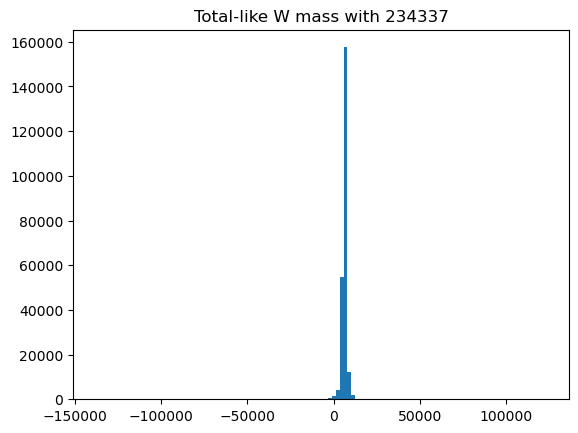

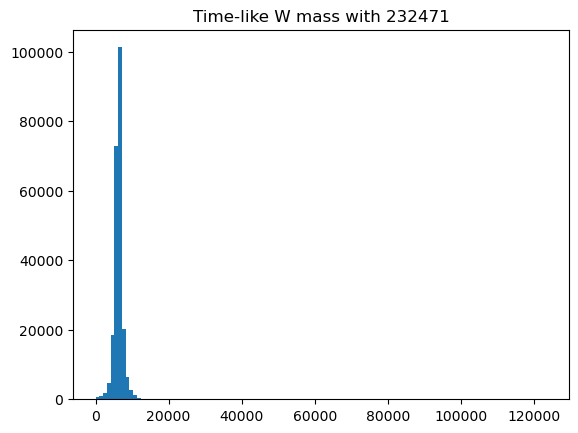

In [13]:
time_like = np.square(pred_w_lead_p4[:, 3]) - np.sum(
    np.square(pred_w_lead_p4[:, 0:-1]), axis=1
)
time_mask = time_like > 0
plt.hist(time_like, bins=120, fill=True)
plt.title(f"Total-like W mass with {len(time_like)}")
plt.show()
plt.hist(time_like[time_mask], bins=120, fill=True)
plt.title(f"Time-like W mass with {len(time_like[time_mask])}")
plt.show()

In [14]:
# truth
truth_pred_w_lead_px = truth_pred_int_lead[:, 0]
truth_pred_w_lead_py = truth_pred_int_lead[:, 1]
truth_pred_w_lead_pz = truth_pred_int_lead[:, 2]
truth_pred_w_lead_energy = truth_pred_int_lead[:, 3]
truth_pred_w_lead_p4 = np.vstack(
    [
        truth_pred_w_lead_px,
        truth_pred_w_lead_py,
        truth_pred_w_lead_pz,
        truth_pred_w_lead_energy,
    ]
).T
truth_pred_w_sublead_px = truth_pred_int_sublead[:, 0]
truth_pred_w_sublead_py = truth_pred_int_sublead[:, 1]
truth_pred_w_sublead_pz = truth_pred_int_sublead[:, 2]
truth_pred_w_sublead_energy = truth_pred_int_sublead[:, 3]
truth_pred_w_sublead_p4 = np.vstack(
    [
        truth_pred_w_sublead_px,
        truth_pred_w_sublead_py,
        truth_pred_w_sublead_pz,
        truth_pred_w_sublead_energy,
    ]
).T

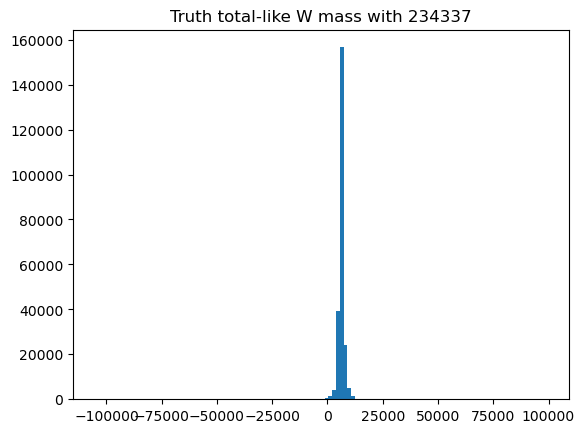

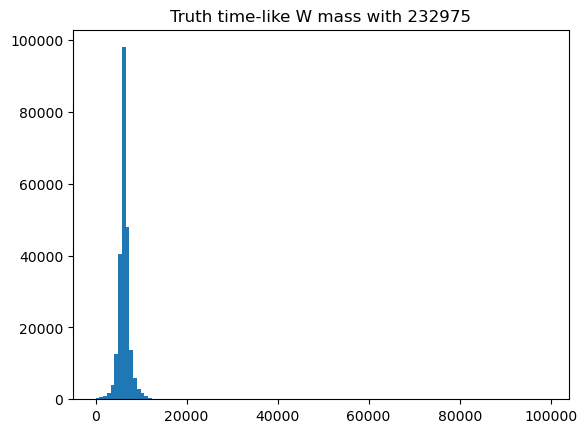

In [15]:
truth_time_like = np.square(truth_pred_w_lead_p4[:, 3]) - np.sum(
    np.square(truth_pred_w_lead_p4[:, 0:-1]), axis=1
)
truth_time_mask = truth_time_like > 0
plt.hist(truth_time_like, bins=120, fill=True)
plt.title(f"Truth total-like W mass with {len(truth_time_like)}")
plt.show()
plt.hist(truth_time_like[truth_time_mask], bins=120, fill=True)
plt.title(f"Truth time-like W mass with {len(truth_time_like[truth_time_mask])}")
plt.show()

In [16]:
# raw Ws
raw_w_lead_p4 = w_lead.p4[PRE_CUT] * GEV
raw_w_sublead_p4 = w_sublead.p4[PRE_CUT] * GEV

In [17]:
def P1(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.cos(phi)


def P2(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (5 * np.cos(theta) + c) * np.sin(theta) * np.sin(phi)


def P3(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 0.25 * (c * 4 * np.cos(theta) + 15 * np.cos(2 * theta) + 5)


def P4(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.cos(2 * phi)


def P5(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return 5 * np.sin(theta) * np.sin(theta) * np.sin(2 * phi)


def P6(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.cos(phi)


def P7(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(2) * (c - 5 * np.cos(theta)) * np.sin(theta) * np.sin(phi)


def P8(theta, phi, sign):
    if sign == "pos":
        c = 1
    elif sign == "neg":
        c = -1
    return np.sqrt(1 / 48) * (c * 12 * np.cos(theta) - 15 * np.cos(2 * theta) - 5)

In [18]:
def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 4.1 test: which lepton nan when boost to W+ and W- frame
    if np.isnan(WpLp_k.Mag()) or np.isnan(WnLp_k.Mag()):
        nan_test = 1
    else:
        nan_test = 0

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 5.1 Calculate GGM
    # GGM
    lp_pt = np.sqrt(
        np.square(WpLp_k.X()) + np.square(WpLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    ln_pt = np.sqrt(
        np.square(WnLp_k.X()) + np.square(WnLp_k.Y())
    )  # pT = sqrt(Px^2 + Py^2)
    lp_phi = np.arctan2(WpLp_k.Y(), WpLp_k.X())  # phi = arctan(Py/Px)
    ln_phi = np.arctan2(WnLp_k.Y(), WnLp_k.X())  # phi = arctan(Py/Px)
    lp_theta = np.arctan(np.divide(lp_pt, WpLp_k.Z()))  # theta = arctan(PT/Pz)
    ln_theta = np.arctan(np.divide(ln_pt, WnLp_k.Z()))  # theta = arctan(PT/Pz)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        np.array([lp_pt, lp_phi, lp_theta]),
        np.array([ln_pt, ln_phi, ln_theta]),
        np.array([nan_test, nan_test, nan_test]),
    )

In [19]:
def result_generator(particles):
    bij = np.zeros((particles.shape[0], 3))
    xi_lead = np.zeros((particles.shape[0], 3))
    xi_sublead = np.zeros((particles.shape[0], 3))
    ggm_lead = np.zeros((particles.shape[0], 3))
    ggm_sublead = np.zeros((particles.shape[0], 3))
    nan_test = np.zeros((particles.shape[0], 3))
    # bunch them together
    result = np.array((particles.shape[0], 3, 6))
    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(Bij, particles)))
    bij = result[:, 0]
    xi_lead = result[:, 1]
    xi_sublead = result[:, 2]
    ggm_lead = result[:, 3]
    ggm_sublead = result[:, 4]
    mask = np.any(np.isnan(bij), axis=1)
    nan_test = np.sum(result[:, 5], axis=1) != 0
    return (
        bij[~mask, :],
        xi_lead[~mask, :],
        xi_sublead[~mask, :],
        ggm_lead[~mask, :],
        ggm_sublead[~mask, :],
        mask,
        nan_test,
    )

In [20]:
# reco
particles = np.concatenate(
    [
        pred_w_lead_p4,
        GEV * lead_lep.p4[PRE_CUT],
        pred_w_sublead_p4,
        GEV * sublead_lep.p4[PRE_CUT],
    ],
    axis=1,
)
(
    bij_cleaned,
    xi_lead_cleaned,
    xi_sublead_cleaned,
    ggm_lead_cleaned,
    ggm_sublead_cleaned,
    mask,
    nan_test,
) = result_generator(particles)
# check boost-nan and bij-nan
print(np.all(mask == nan_test))

# truth
particles = np.concatenate(
    [
        truth_pred_w_lead_p4,
        GEV * truth_lead_lep.p4[PRE_CUT],
        truth_pred_w_sublead_p4,
        GEV * truth_sublead_lep.p4[PRE_CUT],
    ],
    axis=1,
)
(
    truth_bij_cleaned,
    truth_xi_lead_cleaned,
    truth_xi_sublead_cleaned,
    truth_ggm_lead_cleaned,
    truth_ggm_sublead_cleaned,
    truth_mask,
    truth_nan_test,
) = result_generator(particles)
# check boost-nan and bij-nan
print(np.all(truth_mask == truth_nan_test))

# raw
particles = np.concatenate(
    [
        raw_w_lead_p4,
        GEV * truth_lead_lep.p4[PRE_CUT],
        raw_w_sublead_p4,
        GEV * truth_sublead_lep.p4[PRE_CUT],
    ],
    axis=1,
)
bij, xi_lead, xi_sublead, ggm_lead, ggm_sublead, mask_raw, nan_test_raw = (
    result_generator(particles)
)
# check boost-nan and bij-nan
print(np.all(mask_raw == nan_test_raw))

True
True
True


In [21]:
def test(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()

    return WpLepton, WnLepton


def test_generator(particles):

    with multiprocessing.Pool(WORKERS) as pool:
        result = np.array(list(pool.map(test, particles)))

    return result

In [22]:
# def ci(data):
#     res = stats.bootstrap(
#         (data,),
#         statistic=np.mean,
#         confidence_level=0.95,
#         n_resamples=1_024,
#         vectorized=True,
#         alternative="two-sided",
#         method="BCa",
#         random_state=RNG,
#         batch=16_384,
#     )
#     return res.confidence_interval

In [23]:
# with multiprocessing.Pool(WORKERS) as pool:
#     reco_ci = pool.map(ci, bij_cleaned.T)
#     reco_ci_xy_low, reco_ci_xy_high = reco_ci[0][0], reco_ci[0][1]
#     reco_ci_yz_low, reco_ci_yz_high = reco_ci[1][0], reco_ci[1][1]
#     reco_ci_zx_low, reco_ci_zx_high = reco_ci[2][0], reco_ci[2][1]
# print(
#     f"""
# <RECO>: EVT_NUM: {len(bij_cleaned)}
# Bxy: mean = {bij_cleaned[:, 0].mean():<.3f} with 95%CI: -{bij_cleaned[:, 0].mean() - reco_ci_xy_low:<.3f}; +{reco_ci_xy_high - bij_cleaned[:, 0].mean():<.3f}
# Byz: mean = {bij_cleaned[:, 1].mean():<.3f} with 95%CI: -{bij_cleaned[:, 1].mean() - reco_ci_yz_low:<.3f}; +{reco_ci_yz_high - bij_cleaned[:, 1].mean():<.3f}
# Bzx: mean = {bij_cleaned[:, 2].mean():<.3f} with 95%CI: -{bij_cleaned[:, 2].mean() - reco_ci_zx_low:<.3f}; +{reco_ci_zx_high - bij_cleaned[:, 2].mean():<.3f}"""
# )

# truth_Bij = pd.read_hdf(path, "truth_Bij")
# truth_Bij = truth_Bij.to_numpy()
# with multiprocessing.Pool(WORKERS) as pool:
#     truth_ci = pool.map(ci, truth_Bij.T)
#     truth_ci_xy_low, truth_ci_xy_high = truth_ci[0][0], truth_ci[0][1]
#     truth_ci_yz_low, truth_ci_yz_high = truth_ci[1][0], truth_ci[1][1]
#     truth_ci_zx_low, truth_ci_zx_high = truth_ci[2][0], truth_ci[2][1]
# print(
#     f"""
# <TRUTH>: EVT_NUM: {len(truth_Bij)}
# Bxy: mean = {truth_Bij[:, 0].mean():<.3f} with 95%CI: -{truth_Bij[:, 0].mean() - truth_ci_xy_low:<.3f}; +{truth_ci_xy_high - truth_Bij[:, 0].mean():<.3f}
# Byz: mean = {truth_Bij[:, 1].mean():<.3f} with 95%CI: -{truth_Bij[:, 1].mean() - truth_ci_yz_low:<.3f}; +{truth_ci_yz_high - truth_Bij[:, 1].mean():<.3f}
# Bzx: mean = {truth_Bij[:, 2].mean():<.3f} with 95%CI: -{truth_Bij[:, 2].mean() - truth_ci_zx_low:<.3f}; +{truth_ci_zx_high - truth_Bij[:, 2].mean():<.3f}"""
# )

In [24]:
# leading
# reco
w_lead_pt = pt(pred_w_lead_px, pred_w_lead_py)
w_lead_eta = eta(pred_w_lead_px, pred_w_lead_py, pred_w_lead_pz)
w_lead_phi = phi(pred_w_lead_px, pred_w_lead_py)
# truth
truth_w_lead_pt = pt(truth_pred_w_lead_px, truth_pred_w_lead_py)
truth_w_lead_eta = eta(truth_pred_w_lead_px, truth_pred_w_lead_py, truth_pred_w_lead_pz)
truth_w_lead_phi = phi(truth_pred_w_lead_px, truth_pred_w_lead_py)
# raw
raw_w_lead_pt = pt(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1])
raw_w_lead_eta = eta(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1], raw_w_lead_p4[:, 2])
raw_w_lead_phi = phi(raw_w_lead_p4[:, 0], raw_w_lead_p4[:, 1])

# subleading
# reco
w_sublead_pt = pt(pred_w_sublead_px, pred_w_sublead_py)
w_sublead_eta = eta(pred_w_sublead_px, pred_w_sublead_py, pred_w_sublead_pz)
w_sublead_phi = phi(pred_w_sublead_px, pred_w_sublead_py)
# truth
truth_w_sublead_pt = pt(truth_pred_w_sublead_px, truth_pred_w_sublead_py)
truth_w_sublead_eta = eta(truth_pred_w_sublead_px, truth_pred_w_sublead_py, truth_pred_w_sublead_pz)
truth_w_sublead_phi = phi(truth_pred_w_sublead_px, truth_pred_w_sublead_py)
# raw
raw_w_sublead_pt = pt(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1])
raw_w_sublead_eta = eta(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1], raw_w_sublead_p4[:, 2])
raw_w_sublead_phi = phi(raw_w_sublead_p4[:, 0], raw_w_sublead_p4[:, 1])

In [25]:
truth_Bij = pd.read_hdf(data_path, "truth_Bij")


def der_org_plot(
    reco_data,
    truth_data,
    title="Bxy",
    raw_data=truth_Bij["Bxy"],
    unit=None,
    rmse=False,
    density=True,
):
    min_data = np.min([np.min(reco_data), np.min(truth_data), np.min(raw_data)])
    max_data = np.max([np.max(reco_data), np.max(truth_data), np.max(raw_data)])
    bin_edges = np.linspace(min_data, max_data, 121)
    plt.figure(figsize=(7, 5), dpi=100)
    hist = plt.hist(
        reco_data,
        density=density,
        bins=bin_edges,
        color="r",
        histtype="step",
        alpha=1,
        label="Reco",
    )
    hist = plt.hist(
        truth_data,
        density=density,
        bins=bin_edges,
        color="b",
        histtype="step",
        alpha=1,
        label="True",
    )
    if raw_data is not None:
        hist = plt.hist(
            raw_data,
            density=density,
            bins=bin_edges,
            color="grey",
            alpha=0.2,
            fill=True,
            label="label",
        )
    if unit is None:
        plt.xlabel("Null", fontsize=12)
    else:
        plt.xlabel(unit, fontsize=12)
    plt.ylabel("Norm. Count", fontsize=12)
    if rmse is True:
        plt.title(
            title
            + f" with RMSE: {np.sqrt(mean_squared_error(truth_data, reco_data)):.3f}",
            fontsize=16,
        )
    else:
        plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

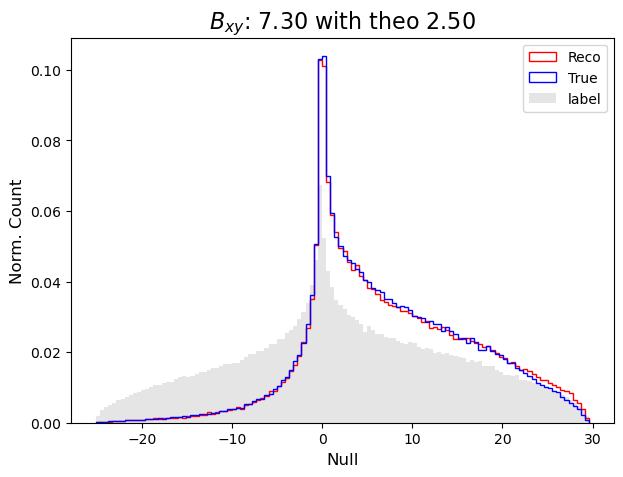

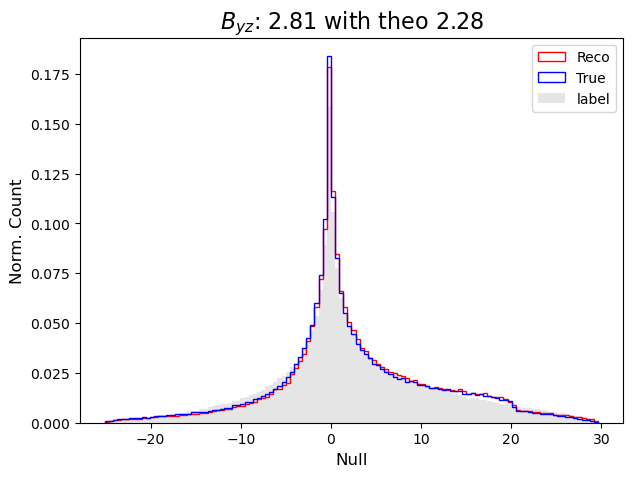

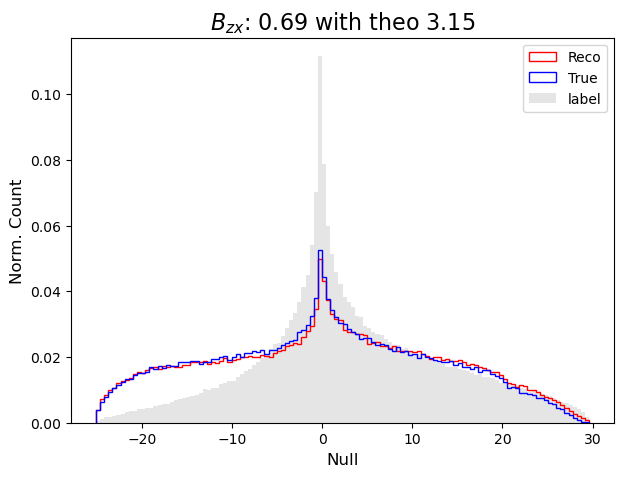

In [26]:
der_org_plot(bij_cleaned[:, 0], truth_bij_cleaned[:, 0], r"$B_{xy}$: " + f"{np.mean(bij_cleaned[:, 0]):<.2f} with theo {np.mean(truth_Bij['Bxy']):<.2f}", truth_Bij["Bxy"], rmse=False)
der_org_plot(bij_cleaned[:, 1], truth_bij_cleaned[:, 1], r"$B_{yz}$: " + f"{np.mean(bij_cleaned[:, 1]):<.2f} with theo {np.mean(truth_Bij['Byz']):<.2f}", truth_Bij["Byz"], rmse=False)
der_org_plot(bij_cleaned[:, 2], truth_bij_cleaned[:, 2], r"$B_{zx}$: " + f"{np.mean(bij_cleaned[:, 2]):<.2f} with theo {np.mean(truth_Bij['Bzx']):<.2f}", truth_Bij["Bzx"], rmse=False)

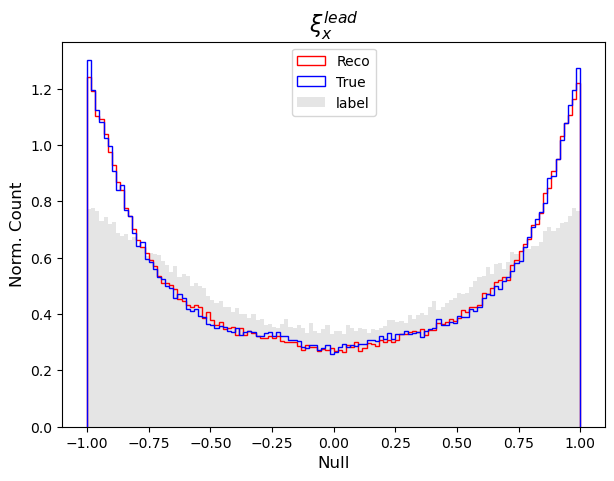

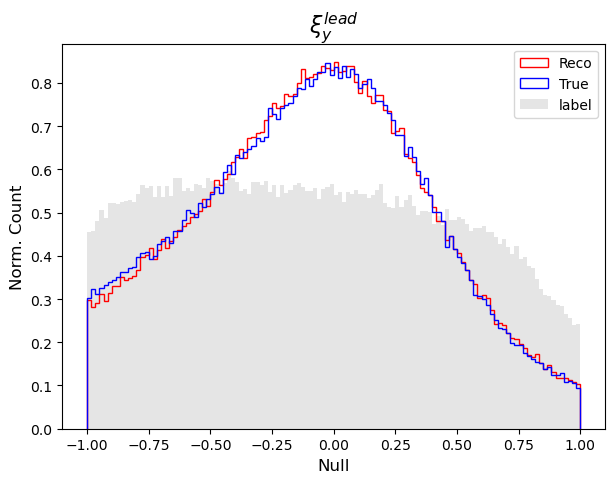

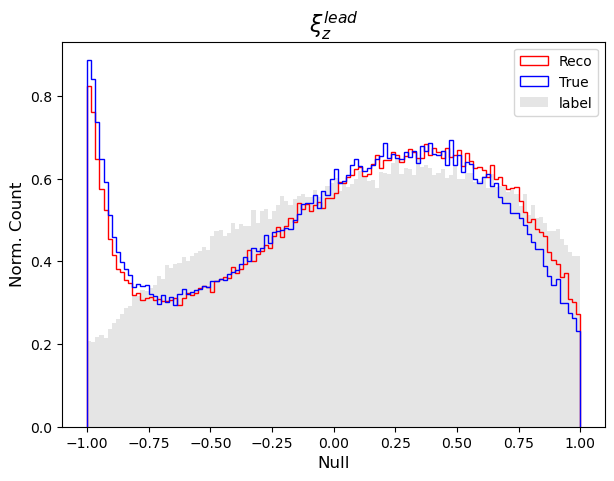

In [27]:
der_org_plot(xi_lead_cleaned[:, 0], truth_xi_lead_cleaned[:, 0], r"$\xi^{lead}_{x}$", raw_data=xi_lead[:, 0])
der_org_plot(xi_lead_cleaned[:, 1], truth_xi_lead_cleaned[:, 1], r"$\xi^{lead}_{y}$", raw_data=xi_lead[:, 1])
der_org_plot(xi_lead_cleaned[:, 2], truth_xi_lead_cleaned[:, 2], r"$\xi^{lead}_{z}$", raw_data=xi_lead[:, 2])

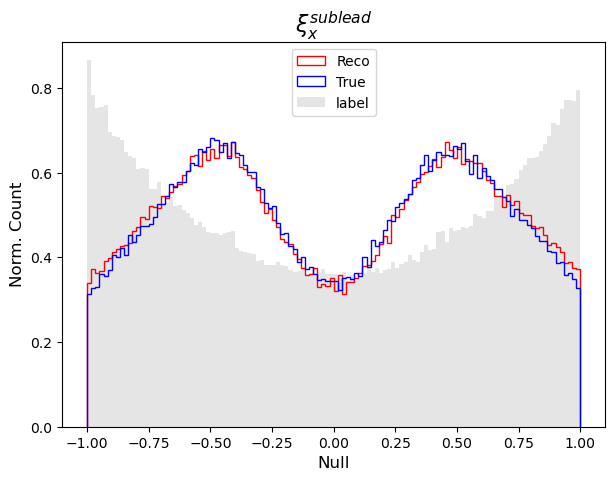

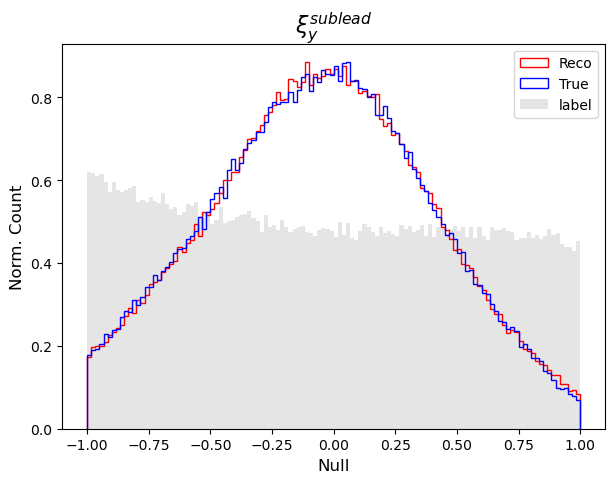

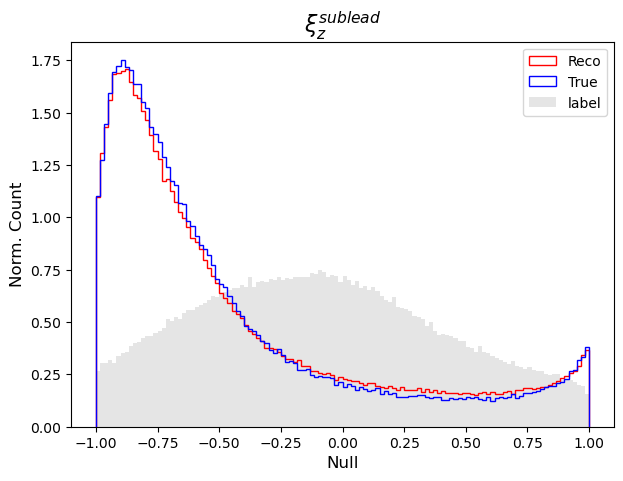

In [28]:
der_org_plot(xi_sublead_cleaned[:, 0], truth_xi_sublead_cleaned[:, 0], r"$\xi^{sublead}_{x}$", raw_data=xi_sublead[:, 0])
der_org_plot(xi_sublead_cleaned[:, 1], truth_xi_sublead_cleaned[:, 1], r"$\xi^{sublead}_{y}$", raw_data=xi_sublead[:, 1])
der_org_plot(xi_sublead_cleaned[:, 2], truth_xi_sublead_cleaned[:, 2], r"$\xi^{sublead}_{z}$", raw_data=xi_sublead[:, 2])

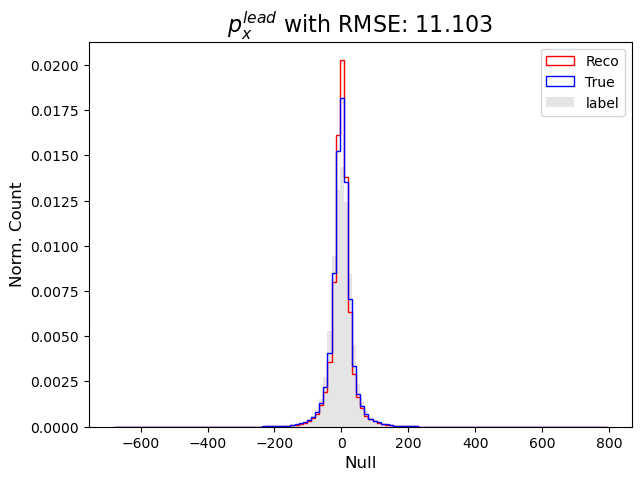

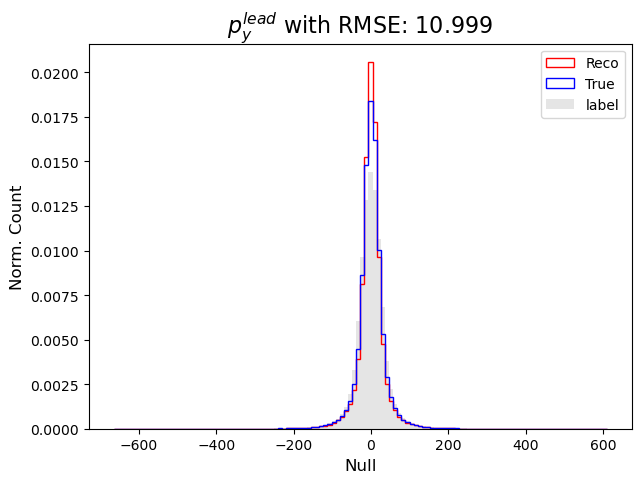

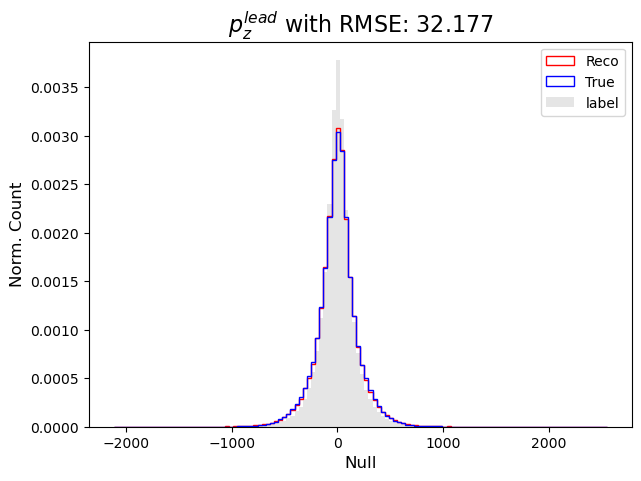

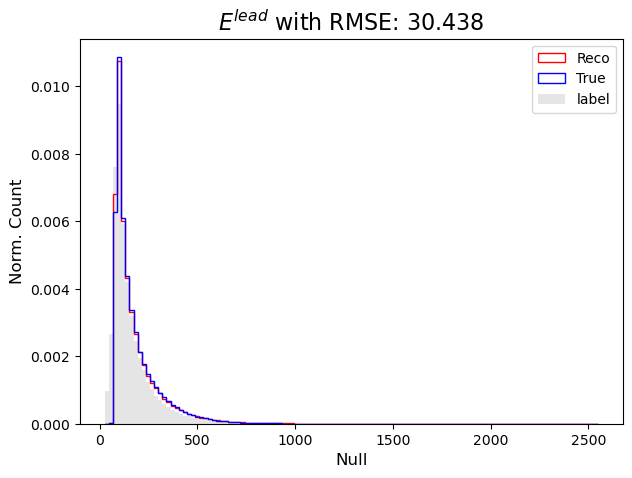

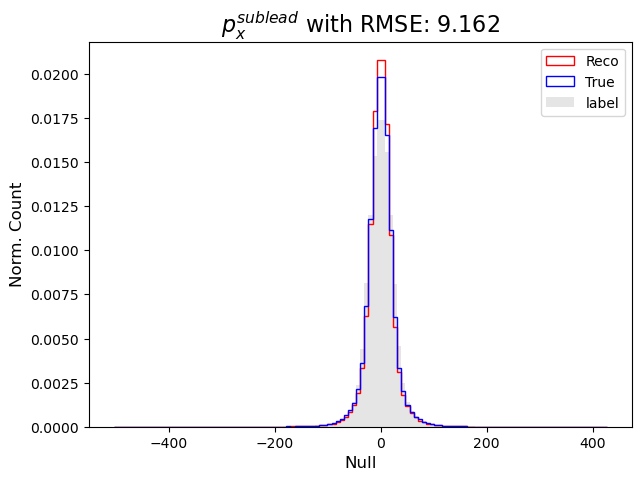

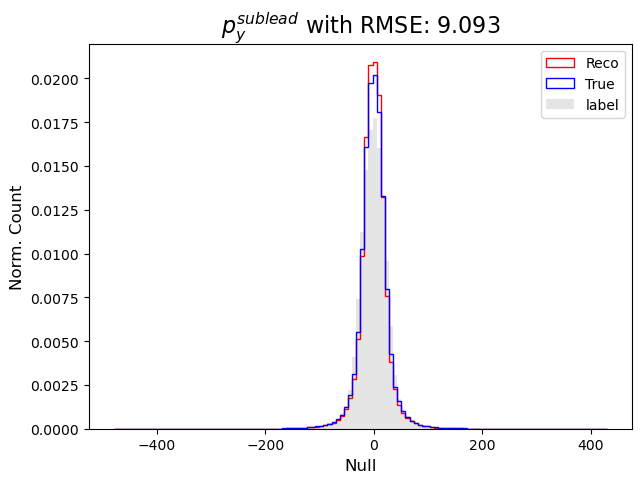

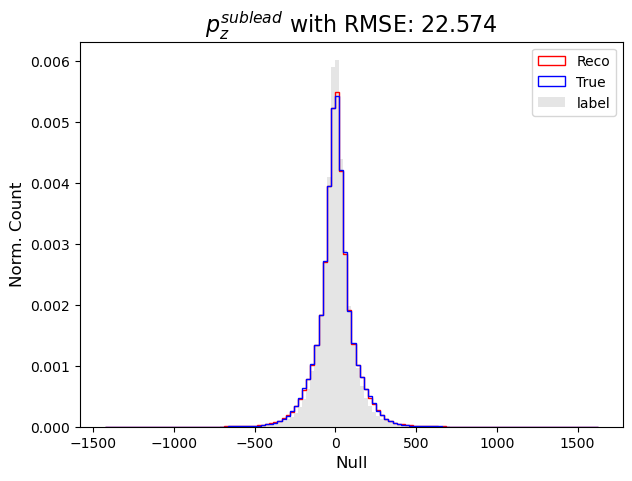

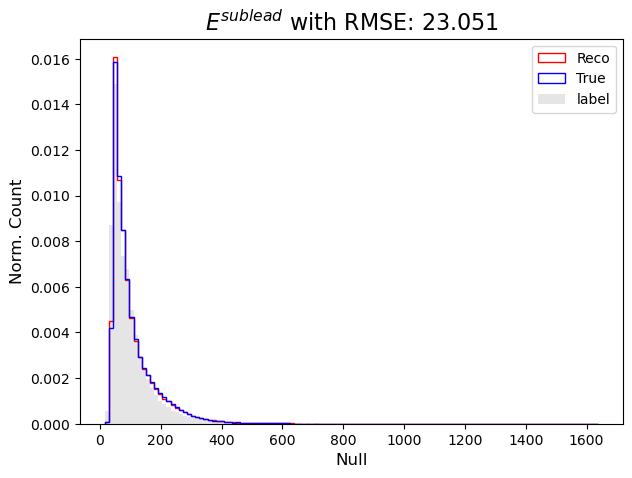

In [29]:
# lead
der_org_plot(
    pred_w_lead_px,
    truth_pred_w_lead_px,
    r"$p_{x}^{lead}$",
    raw_data=raw_w_lead_p4[:, 0],
    rmse=True,
)
der_org_plot(
    pred_w_lead_py,
    truth_pred_w_lead_py,
    r"$p_{y}^{lead}$",
    raw_data=raw_w_lead_p4[:, 1],
    rmse=True,
)
der_org_plot(
    pred_w_lead_pz,
    truth_pred_w_lead_pz,
    r"$p_{z}^{lead}$",
    raw_data=raw_w_lead_p4[:, 2],
    rmse=True,
)
der_org_plot(
    pred_w_lead_energy,
    truth_pred_w_lead_energy,
    r"$E^{lead}$",
    raw_data=raw_w_lead_p4[:, 3],
    rmse=True,
)
# sublead
der_org_plot(
    pred_w_sublead_px,
    truth_pred_w_sublead_px,
    r"$p_{x}^{sublead}$",
    raw_data=raw_w_sublead_p4[:, 0],
    rmse=True,
)
der_org_plot(
    pred_w_sublead_py,
    truth_pred_w_sublead_py,
    r"$p_{y}^{sublead}$",
    raw_data=raw_w_sublead_p4[:, 1],
    rmse=True,
)
der_org_plot(
    pred_w_sublead_pz,
    truth_pred_w_sublead_pz,
    r"$p_{z}^{sublead}$",
    raw_data=raw_w_sublead_p4[:, 2],
    rmse=True,
)
der_org_plot(
    pred_w_sublead_energy,
    truth_pred_w_sublead_energy,
    r"$E^{sublead}$",
    raw_data=raw_w_sublead_p4[:, 3],
    rmse=True,
)

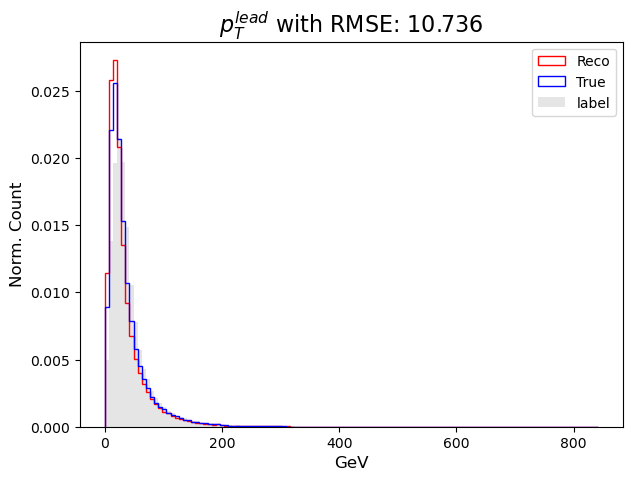

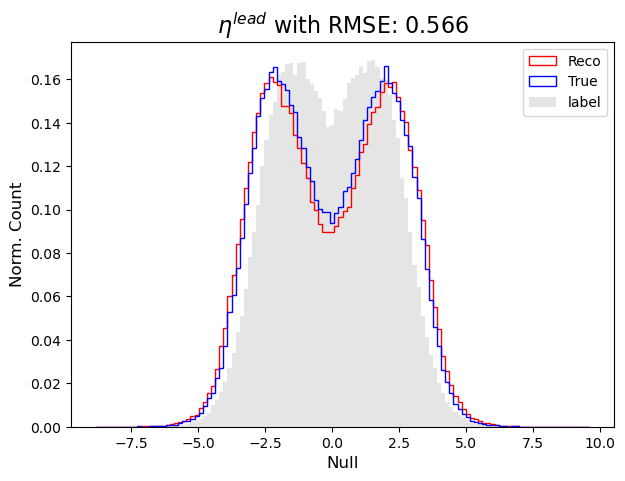

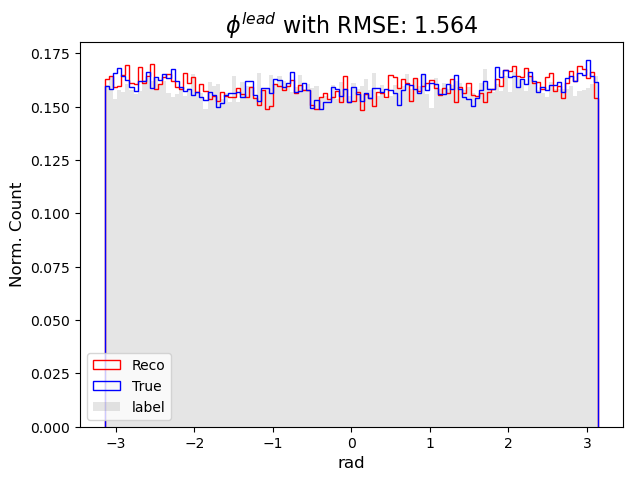

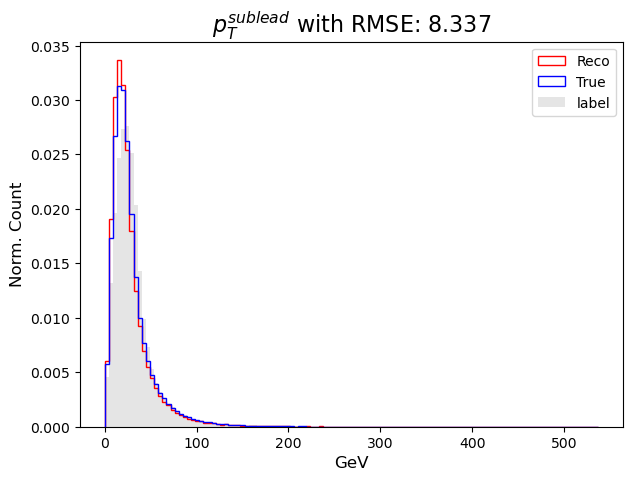

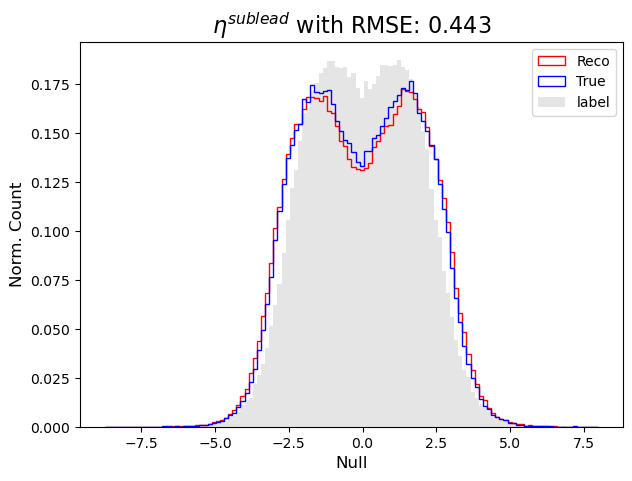

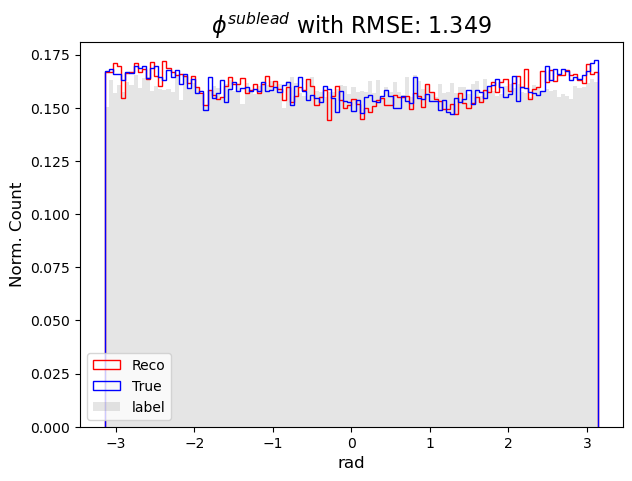

In [30]:
# leading
der_org_plot(
    w_lead_pt,
    truth_w_lead_pt,
    r"$p^{lead}_{T}$",
    unit="GeV",
    raw_data=raw_w_lead_pt,
    rmse=True,
)
der_org_plot(
    w_lead_eta, truth_w_lead_eta, r"$\eta^{lead}$", raw_data=raw_w_lead_eta, rmse=True
)
der_org_plot(
    w_lead_phi,
    truth_w_lead_phi,
    r"$\phi^{lead}$",
    unit="rad",
    raw_data=raw_w_lead_phi,
    rmse=True,
)
# subleading
der_org_plot(
    w_sublead_pt,
    truth_w_sublead_pt,
    r"$p^{sublead}_{T}$",
    unit="GeV",
    raw_data=raw_w_sublead_pt,
    rmse=True,
)
der_org_plot(
    w_sublead_eta,
    truth_w_sublead_eta,
    r"$\eta^{sublead}$",
    raw_data=raw_w_sublead_eta,
    rmse=True,
)
der_org_plot(
    w_sublead_phi,
    truth_w_sublead_phi,
    r"$\phi^{sublead}$",
    unit="rad",
    raw_data=raw_w_sublead_phi,
    rmse=True,
)

In [31]:
def miss_plot(full_data, miss_data, title=r"$\eta_{lead}$", unit=None, density=True):
    min_data = np.min([np.min(full_data), np.min(miss_data)])
    max_data = np.max([np.max(full_data), np.max(miss_data)])
    bins_edges = np.linspace(min_data, max_data, 121)
    plt.figure(figsize=(7, 5), dpi=120)
    plt.hist(
        [miss_data, full_data],
        bins=bins_edges,
        density=density,
        alpha=0.8,
        label=["fail", "pass"],
        stacked=True,
    )
    if unit:
        plt.xlabel(unit, fontsize=12)
    else:
        plt.xlabel("Null", fontsize=12)
    if density is True:
        plt.ylabel("Norm. Count", fontsize=12)
    else:
        plt.ylabel("Count", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()


def miss_w_plot(
    pass_data, miss_data, raw_data, title=r"$\eta_{lead}$", unit=None, density=True
):
    min_data = np.min([np.min(pass_data), np.min(miss_data), np.min(raw_data)])
    max_data = np.max([np.max(pass_data), np.max(miss_data), np.max(raw_data)])
    bins_edges = np.linspace(min_data, max_data, 121)
    plt.figure(figsize=(7, 5), dpi=120)
    plt.hist(
        [miss_data, pass_data],
        bins=bins_edges,
        density=density,
        alpha=0.8,
        label=["fail", "pass"],
        stacked=True,
    )
    plt.hist(
        raw_data,
        bins=bins_edges,
        density=density,
        alpha=1.0,
        label="label",
        histtype="step",
        stacked=False,
        color="grey",
    )
    if unit:
        plt.xlabel(unit, fontsize=12)
    else:
        plt.xlabel("Null", fontsize=12)
    if density is True:
        plt.ylabel("Norm. Count", fontsize=12)
    else:
        plt.ylabel("Count", fontsize=12)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    plt.close()

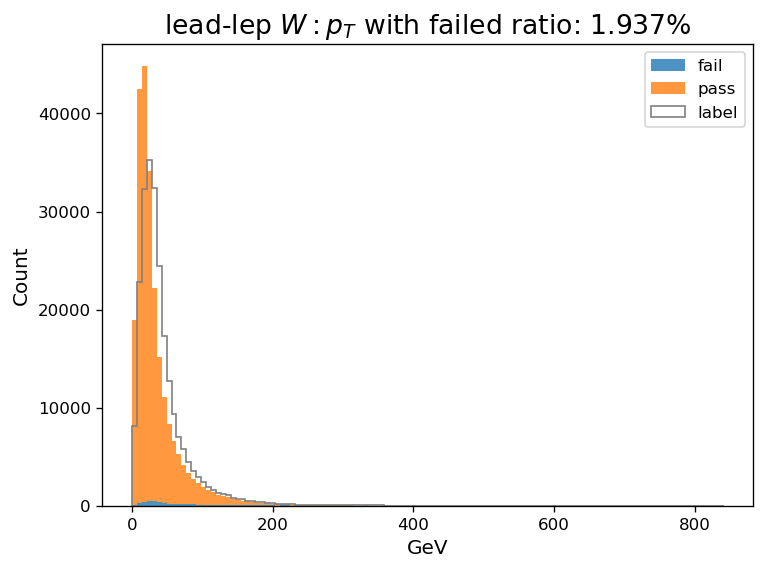

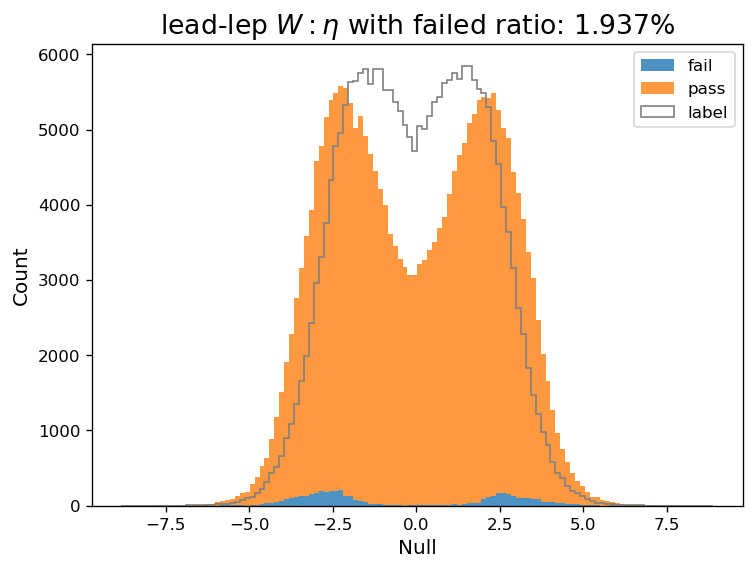

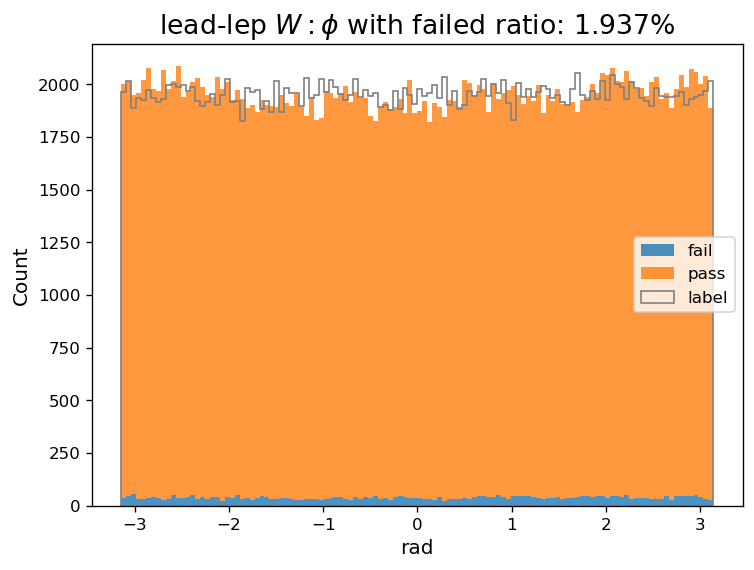

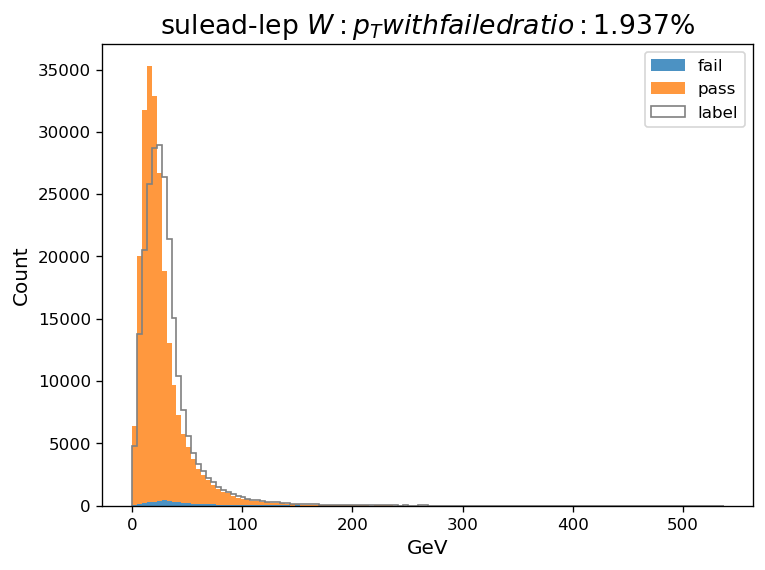

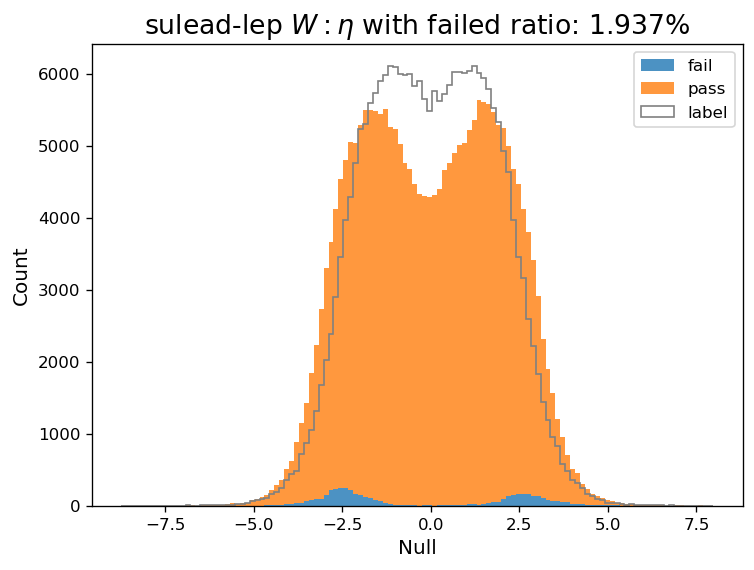

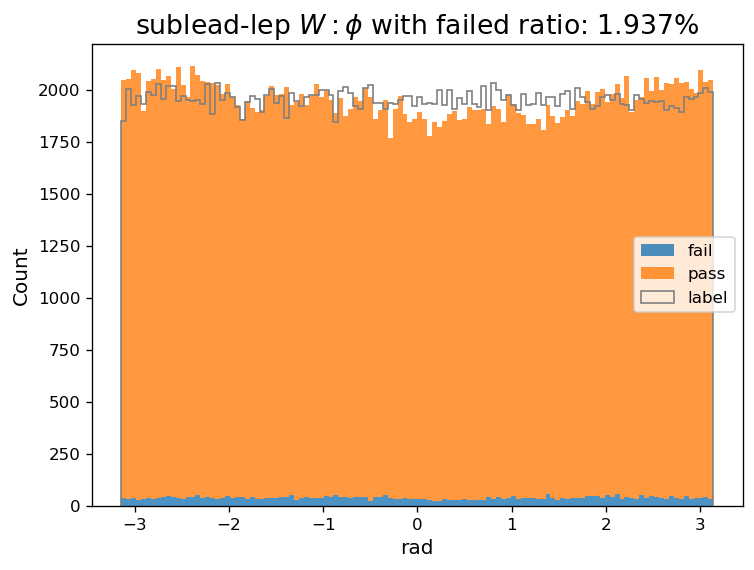

In [32]:
# lead
miss_w_plot(
    w_lead_pt[~mask],
    w_lead_pt[mask],
    raw_w_lead_pt,
    r"lead-lep $W: p_{T}$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="GeV",
    density=False,
)
miss_w_plot(
    w_lead_eta[~mask],
    w_lead_eta[mask],
    raw_w_lead_eta,
    r"lead-lep $W: \eta$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="Null",
    density=False,
)
miss_w_plot(
    w_lead_phi[~mask],
    w_lead_phi[mask],
    raw_w_lead_phi,
    r"lead-lep $W: \phi$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="rad",
    density=False,
)

# sublead
miss_w_plot(
    w_sublead_pt[~mask],
    w_sublead_pt[mask],
    raw_w_sublead_pt,
    r"sulead-lep $W: p_{T} with failed ratio: $" + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="GeV",
    density=False,
)
miss_w_plot(
    w_sublead_eta[~mask],
    w_sublead_eta[mask],
    raw_w_sublead_eta,
    r"sulead-lep $W: \eta$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="Null",
    density=False,
)
miss_w_plot(
    w_sublead_phi[~mask],
    w_sublead_phi[mask],
    raw_w_sublead_phi,
    r"sublead-lep $W: \phi$ with failed ratio: " + f"{100 * np.sum(mask)/len(mask):.3f}%",
    unit="rad",
    density=False,
)

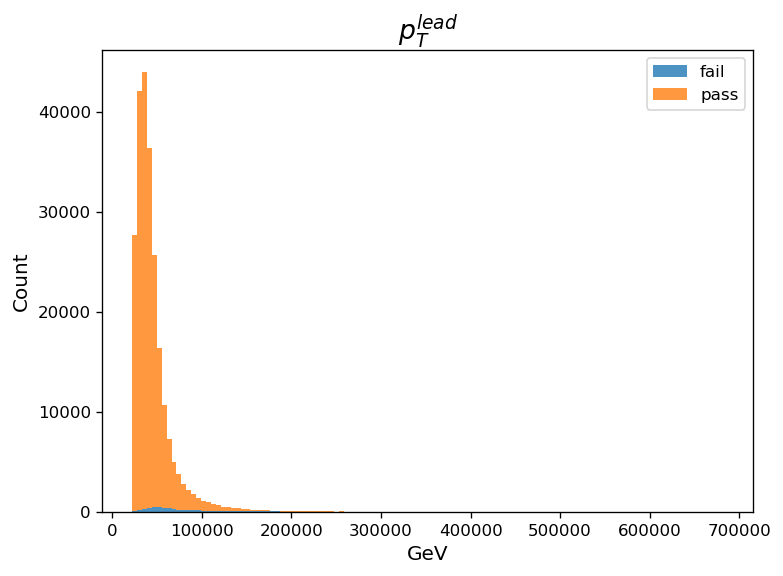

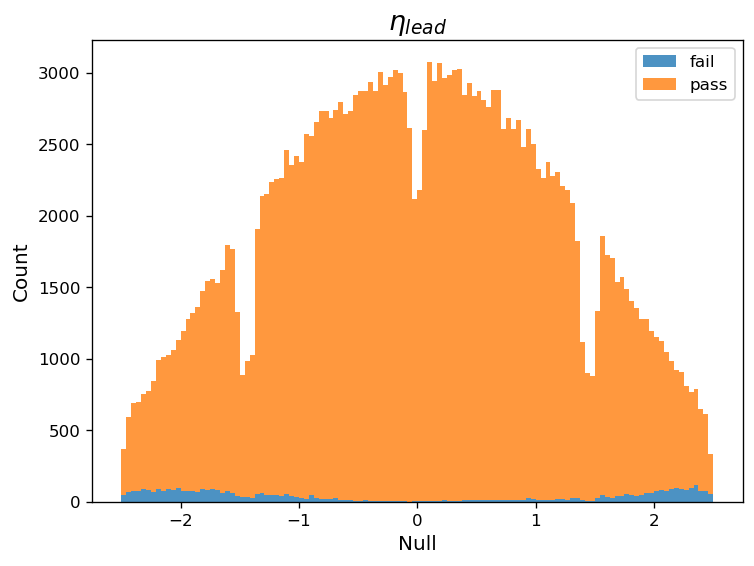

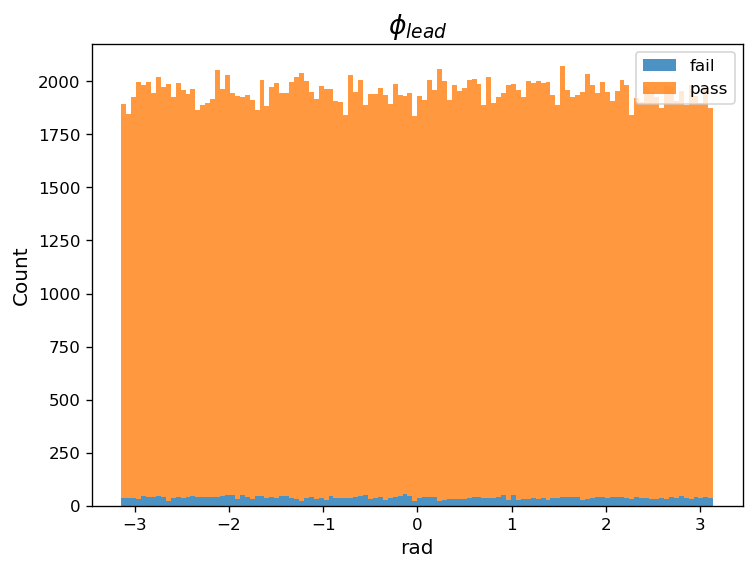

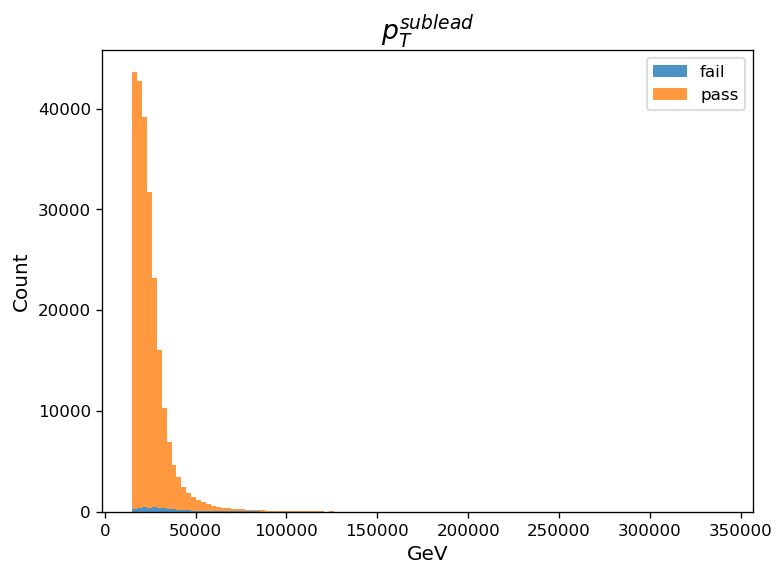

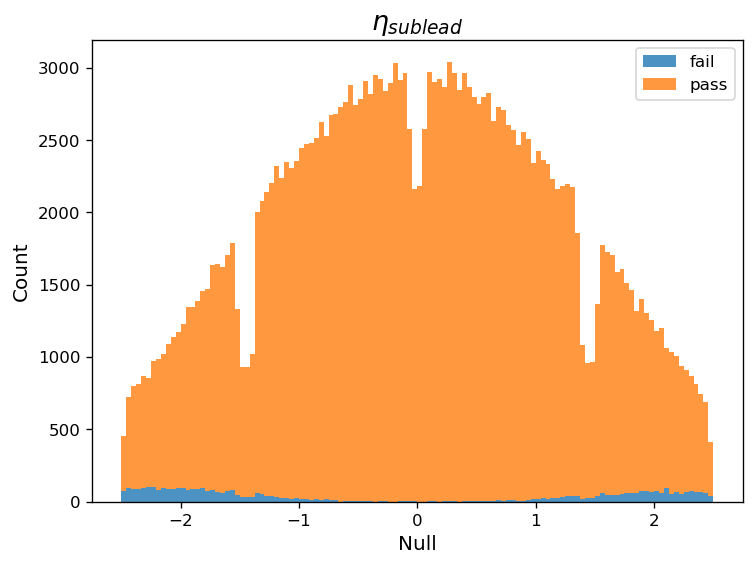

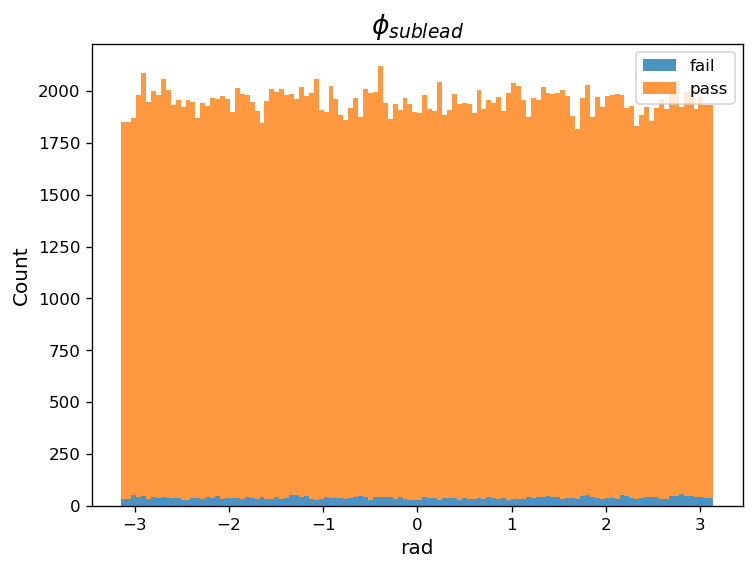

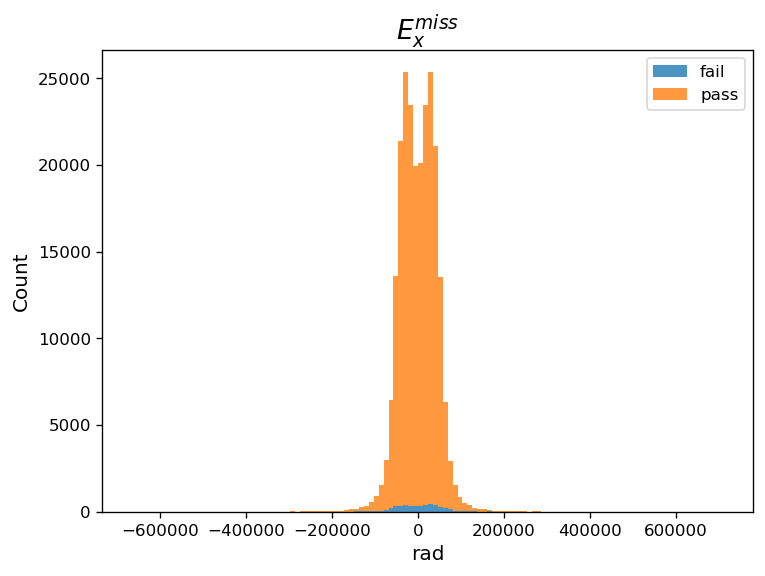

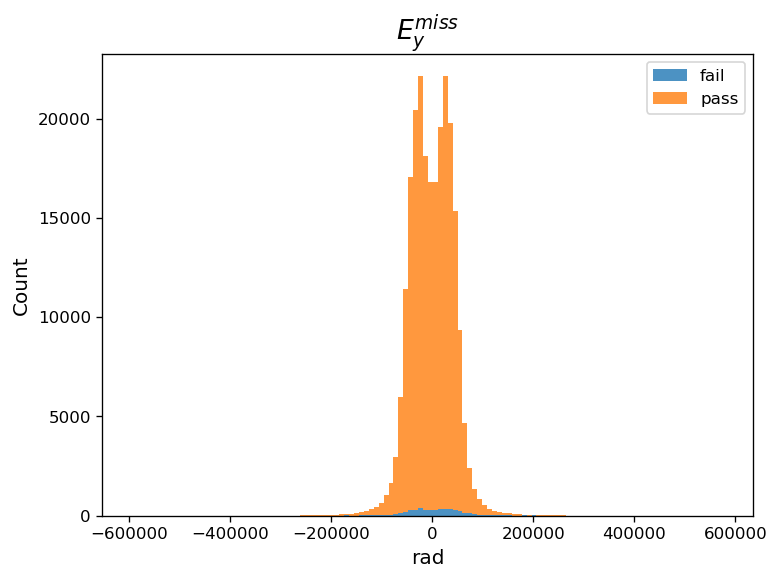

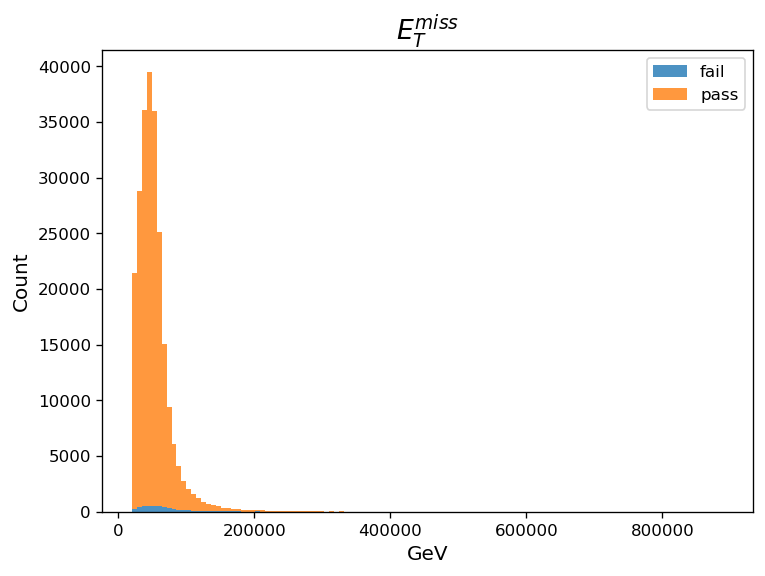

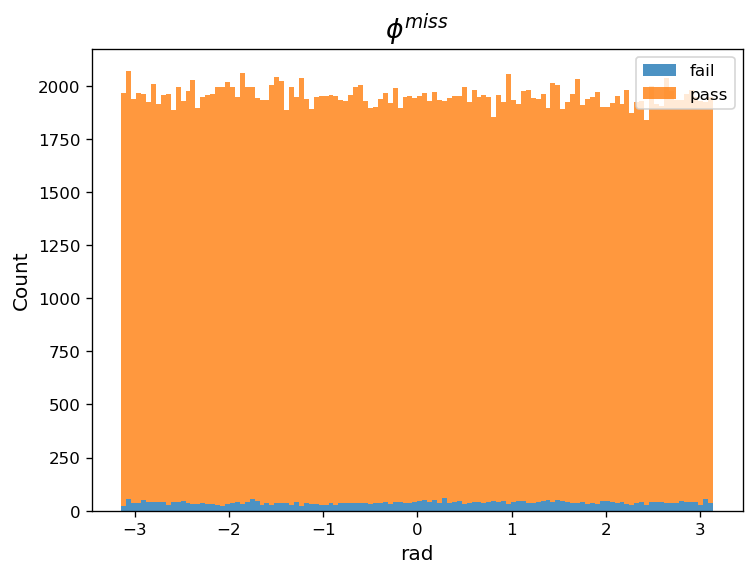

In [33]:
# lead
miss_plot(
    lead_lep.pt[PRE_CUT][~mask], lead_lep.pt[PRE_CUT][mask], r"$p_{T}^{lead}$", unit="GeV", density=False
)
miss_plot(lead_lep.eta[PRE_CUT][~mask], lead_lep.eta[PRE_CUT][mask], r"$\eta_{lead}$", density=False)
miss_plot(
    lead_lep.phi[PRE_CUT][~mask], lead_lep.phi[PRE_CUT][mask], r"$\phi_{lead}$", unit="rad", density=False
)
# sublead
miss_plot(
    sublead_lep.pt[PRE_CUT][~mask],
    sublead_lep.pt[PRE_CUT][mask],
    r"$p_{T}^{sublead}$",
    unit="GeV",
    density=False,
)
miss_plot(
    sublead_lep.eta[PRE_CUT][~mask], sublead_lep.eta[PRE_CUT][mask], r"$\eta_{sublead}$", density=False
)
miss_plot(
    sublead_lep.phi[PRE_CUT][~mask],
    sublead_lep.phi[PRE_CUT][mask],
    r"$\phi_{sublead}$",
    unit="rad",
    density=False,
)
# met
miss_plot(
    met.px[PRE_CUT][~mask],
    met.px[PRE_CUT][mask],
    r"$E^{miss}_{x}$",
    unit="rad",
    density=False,
)
miss_plot(
    met.py[PRE_CUT][~mask],
    met.py[PRE_CUT][mask],
    r"$E^{miss}_{y}$",
    unit="rad",
    density=False,
)
miss_plot(
    met.pt[PRE_CUT][~mask],
    met.pt[PRE_CUT][mask],
    r"$E^{miss}_{T}$",
    unit="GeV",
    density=False,
)
miss_plot(
    met.phi[PRE_CUT][~mask],
    met.phi[PRE_CUT][mask],
    r"$\phi^{miss}$",
    unit="rad",
    density=False,
)

In [34]:
t_end = time.time()
print(f"Total spending time: {t_end-t_start: .2f} (s)")

Total spending time:  282.71 (s)
